<a href="https://colab.research.google.com/github/sunyingjian/AI-in-well-logging/blob/master/%E4%BD%BF%E7%94%A8matplotlib_%E5%8F%AF%E8%A7%86%E5%8C%96_csv%E6%B5%8B%E4%BA%95%E6%95%B0%E6%8D%AE%E5%AE%9E%E7%8E%B0ui%E6%8E%A7%E5%88%B6%E7%9A%84%E6%B5%8B%E4%BA%95%E6%9B%B2%E7%BA%BF%E7%94%9F%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the FORCE 2020 Well Log Challenge - Part 1
## Visualizing the well logs with matplotlib

**Brendon Hall, Enthought**

bhall@enthought.com

It's time for another facies classification challenge! [FORCE](https://www.npd.no/en/force/) and [XEEK](https://xeek.ai/) have teamed up to bring us the [2020 FORCE Machine Learning Contest](https://xeek.ai/challenges/force-well-logs/overview). Peter Borman and his colleagues have curated a set of 100+ well logs from the North Sea. In addition to the log curves, each well has interpreted lithofacies.  This is an awesome addition to the open data that is available for building tools for digital geoscience.  Machine learning based facies classification is a popular subject, and this is an exciting new benchmark dataset.

Since the [SEG Contest](https://github.com/seg/2016-ml-contest) in 2016, I've been impressed [how much innovation](https://www.linkedin.com/pulse/developments-machine-deep-learning-facies-brendon-hall) can come from an open dataset and a community interested in building new tools and techniques.  This time should be even better! The dataset is 10X the size and there are 4 years of new ideas to incorporate.  I thought it would be useful to create a few Jupyter notebooks that provide some ideas for getting started with this dataset. If you're new to Python and programming, this will help get you started exploring the data.  If you are more experienced, perhaps this will enable you to focus more on trying out different features or machine learning models.  In any case, you are welcome to use any or all of this code as you see fit.  If you have any suggestions or ideas for improvement, those are welcome as well.

This notebook will propose a colorbar for visualizing the lithofacies interpretations, and show how to use matplotlib to create a flexible log and lithofacies plot.  This is based on the log plot in my [facies classification tutorial](https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb).  If you are brand new to Python and 'geocomputing', check out this [tutorial](https://www.youtube.com/watch?v=iIOMiN8Cacs&list=PLgLft9vxdduD8Zydz4dRJqIzCWDlPKITC&index=2&t=1241s) by Rob Leckenby to get started.  

Please get in touch if you have any questions!  You can also join in the conversation on [Software Underground's slack](https://softwareunderground.org/slack) in the **#force_2020_ml_contest** channel.

The well log data is licensed as [Norwegian License for Open Government Data (NLOD) 2.0](https://data.norge.no/nlod/en/2.0/).
The well log labels that are included are provided by FORCE 2020 Machine Learning Contest under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/).

In [ ]:
%matplotlib inline

import os.path

import numpy as np
import pandas as pd

import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ipywidgets as widgets

pd.options.display.max_rows = 8

In [ ]:
!git clone https://github.com/sunyingjian/numpy-private.git

Cloning into 'numpy-private'...
remote: Enumerating objects: 553, done.
remote: Total 553 (delta 0), reused 0 (delta 0), pack-reused 553
Receiving objects: 100% (553/553), 279.96 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Checking out files: 100% (539/539), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/Shared\ drives/FORCE\ 2020/挪威比赛.zip -d ./

Archive:  /content/drive/Shared drives/FORCE 2020/挪威比赛.zip
  inflating: ./test.csv              
  inflating: ./train.csv             


Let's start by loading up the training data.

You can get the dataset on the [contest website](https://xeek.ai/challenges/force-well-logs/data).  We'll only use the training dataset for this notebook.  If you have already downloaded the data, change the `local_train_csv` variable below to point to the file.  

If you don't have the data already, you can run the code below and download the data automatically from AWS-S3.  A local copy will be saved at the location specified by `local_train_csv`, so you won't have to download it every time.

Note, we're also making an effort to make the seismic 
data for the [fault competition](https://xeek.ai/challenges/force-seismic/overview) available
from S3, but through a simplified API. See this [repo](https://github.com/blasscoc/easy-as.git)
if you're also interested in the fault mapping competition.

In [ ]:
# change this to the location of the training data on your disk if
# you have already downloaded it
local_train_csv = '/content/train.csv'
wells_df = pd.read_csv(local_train_csv, sep=';')

我们需要数据集中所有井名的列表。

In [ ]:
wells_df

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170507,7/1-2 S,3169.4644,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.379244,NaN,NaN,NaN,2.537613,75.363937,NaN,NaN,7.019858,NaN,NaN,8.5,28.024338,NaN,NaN,-0.007600,NaN,NaN,26.840818,NaN,65030,2.0
1170508,7/1-2 S,3169.6164,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.350248,NaN,NaN,NaN,2.491860,66.452843,NaN,NaN,9.049782,NaN,NaN,8.5,28.091282,NaN,NaN,-0.018297,NaN,NaN,27.007942,NaN,65030,2.0
1170509,7/1-2 S,3169.7684,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.313779,NaN,NaN,NaN,2.447539,55.784817,NaN,NaN,8.903917,NaN,NaN,8.5,28.019775,NaN,NaN,-0.011438,NaN,NaN,27.175179,NaN,65030,2.0
1170510,7/1-2 S,3169.9204,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.294910,NaN,NaN,NaN,2.430716,48.432129,NaN,NaN,9.150043,NaN,NaN,8.5,25.985943,NaN,NaN,-0.011398,NaN,NaN,27.342442,NaN,65030,2.0


In [ ]:
well_names = wells_df['WELL'].unique()

csv中的12个相标具有整数代码。 让我们添加几列，以使人类和机器都更容易理解这些代码。 我们将为岩性添加一个更具描述性的标签，还将添加一个用于可视化的整数值（编号为0-11）（以及以后用于监督式机器学习的标签）

In [ ]:
# map of lithology codes to description
lithology_keys = {30000: 'Sandstone',
                     65030: 'Sandstone/Shale',
                     65000: 'Shale',
                     80000: 'Marl',
                     74000: 'Dolomite',
                     70000: 'Limestone',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Anhydrite',
                     99000: 'Tuff',
                     90000: 'Coal',
                     93000: 'Basement'}
    
# map of lithology codes to integer label for ML
lithology_numbers = {30000: 0,
             65030: 1,
             65000: 2,
             80000: 3,
             74000: 4,
             70000: 5,
             70032: 6,
             88000: 7,
             86000: 8,
             99000: 9,
             90000: 10,
             93000: 11}
    
def map_lith_key(lith_map, row):
    
    lith_key = row['FORCE_2020_LITHOFACIES_LITHOLOGY']
    
    if lith_key in lith_map:
        return lith_map[lith_key]
    else:
        print('Warning: Key {} not found in map'.format(lith_key))
        return np.nan

wells_df['LITHOLOGY'] = wells_df.apply (lambda row: map_lith_key(lithology_keys, row), axis=1)
wells_df['LITH_LABEL'] = wells_df.apply (lambda row: map_lith_key(lithology_numbers, row), axis=1)

In [ ]:
wells_df[['FORCE_2020_LITHOFACIES_LITHOLOGY', 'LITHOLOGY', 'LITH_LABEL']]

,FORCE_2020_LITHOFACIES_LITHOLOGY,LITHOLOGY,LITH_LABEL
0,65000,Shale,2
1,65000,Shale,2
2,65000,Shale,2
3,65000,Shale,2
...,...,...,...
1170507,65030,Sandstone/Shale,1
1170508,65030,Sandstone/Shale,1
1170509,65030,Sandstone/Shale,1
1170510,65030,Sandstone/Shale,1


现在，让我们设置一个颜色图，以使可视化的测井变得更加容易。 在比较机器学习结果时，这也将很有用。 此颜色方案大致基于我[[]之前使用的颜色）。 砂岩为黄色，页岩为绿色，砂岩-页岩介于两者之间。 碳酸盐是蓝色阴影，盐是紫色阴影。 [凝灰岩]（当然是）是熔岩红（当然是），熔岩是黑色，地下室是橙色（因为为什么不）。

如果您想选择其他颜色，这是一个可以帮助您的颜色选择器小部件。 单击颜色选择器工具底部的箭头，以更改为十六进制表示法。

In [ ]:
color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

display(color_picker)

ColorPicker(value='blue', description='Pick a color')

In [ ]:
facies_color_map = { 'Sandstone': '#F4D03F',
                     'Sandstone/Shale': '#7ccc19',
                     'Shale': '#196F3D',
                     'Marl': '#160599',
                     'Dolomite': '#2756c4',
                     'Limestone': '#3891f0',
                     'Chalk': '#80d4ff',
                     'Halite': '#87039e',
                     'Anhydrite': '#ec90fc',
                     'Tuff': '#FF4500',
                     'Coal': '#000000',
                     'Basement': '#DC7633'}

# get a list of the color codes.
facies_colors = [facies_color_map[mykey] for mykey in facies_color_map.keys()]

现在定义一个函数，该函数使用对数曲线以及岩相轨迹创建图。 此图将很灵活，因为我们可以提供要包含在图中的曲线助记符列表。

In [ ]:
def make_facies_log_plot(log_df, curves, facies_colors):
    
    #make sure logs are sorted by depth
    logs = log_df.sort_values(by='DEPTH_MD')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    
    cluster=np.repeat(np.expand_dims(logs['LITH_LABEL'].values,1), 100, 1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs['DEPTH_MD'])
        ax[ic].set_xlabel(col)
        ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=11)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((12*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Ml', 'Dm', 'LS', 'Chk ', 
                                '  Hl', 'Ann', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[num_curves].set_xlabel('Facies')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'%logs.iloc[0]['WELL'], fontsize=14,y=0.94)
    
    plt.show()

让我们尝试一下以获取样本。 包括标准的“三合一”日志。

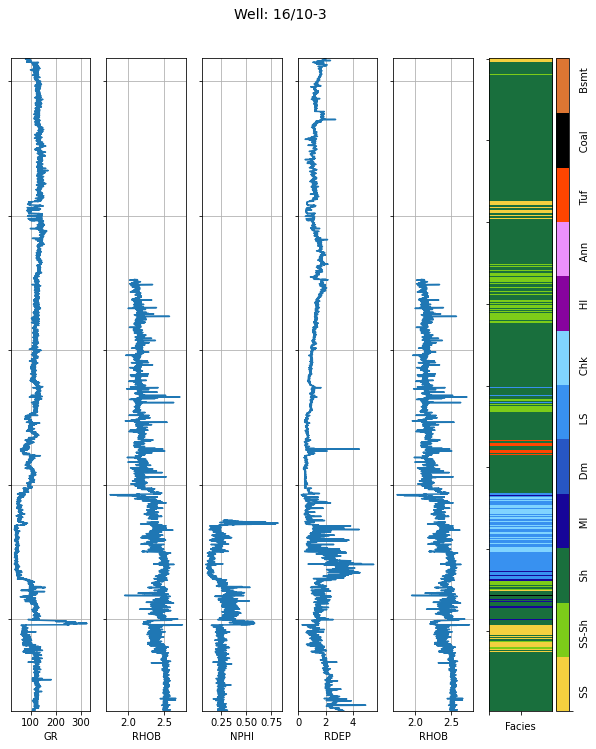

In [ ]:
make_facies_log_plot(
    wells_df[wells_df['WELL'] == '16/10-3'],
    ['GR', 'RHOB', 'NPHI', 'RDEP','RHOB'],
    facies_colors)

现在让我们对所有曲线进行尝试。 首先，定义一个包含所有曲线名称的列表。

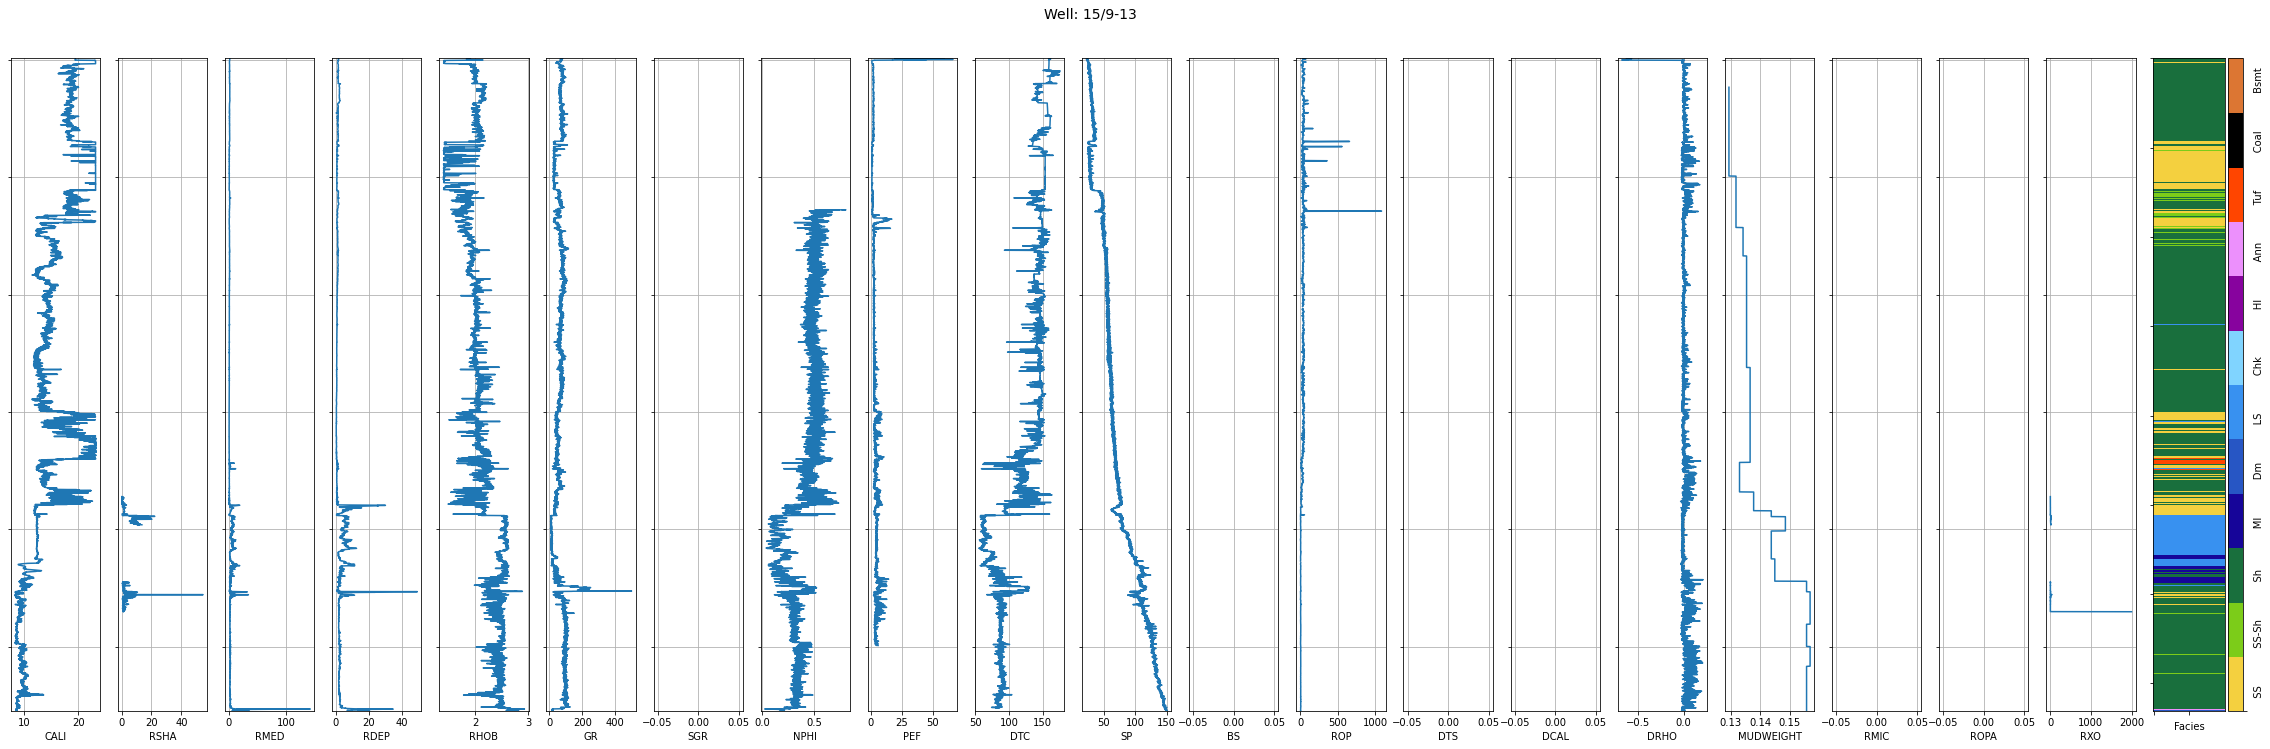

In [ ]:
columns = ['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR',
           'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO',
           'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO']

make_facies_log_plot(
    wells_df[wells_df['WELL'] == '15/9-13'],
    columns,
    facies_colors)

有这么多曲线不太容易读懂，但它快速灵活，在尝试新的机器学习思想时应该很有用。

如果该图更易于定制，那就太酷了。 让我们尝试一下“ ipywidgets”库，该库为我们提供了一些控件来更改绘图参数。 在这里，我们将创建一个下拉菜单，让我们更改显示的状态。 我们将使用一个多选框来指示要在绘图中包含哪些曲线（默认情况下，所有曲线均处于选中状态）。 单击以按住shift，控制（或命令）以选择多个曲线名称。 单击按钮以根据您的选择生成图。

In [ ]:
plot_output = widgets.Output()

dropdown_well = widgets.Dropdown(options = wells_df['WELL'].unique(), description='Well:', value='15/9-13')

select_curves = widgets.SelectMultiple(
    options=columns,
    value=columns,
    #rows=10,
    description='Curves:',
    disabled=False
)

plot_button = widgets.Button(
    description='Show well plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to plot well.'
)
        
def on_button_clicked(b):
    plot_output.clear_output()
    with plot_output:
        make_facies_log_plot(
            wells_df[wells_df['WELL'] == dropdown_well.value],
            select_curves.value,
            facies_colors)
        
plot_button.on_click(on_button_clicked)

display(dropdown_well)
display(select_curves)
display(plot_button)
display(plot_output)

Dropdown(description='Well:', options=('15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1', '16/1…

SelectMultiple(description='Curves:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…

Button(description='Show well plot', style=ButtonStyle(), tooltip='Click to plot well.')

Output()

我希望这会为您提供一些有用的代码，用于在FORCE 2020数据集中绘制井曲线和岩性。 请随时使用任何或所有此代码进行自己的工作。 有很多方法可以可视化Python中的测井记录。 Ashley Russell撰写了很棒的教程，介绍如何在Jupyter中构建交互式测井曲线图。

This notebook is open source content. Text is CC-BY-4.0, code is [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0).

### References

Bormann P., Aursand P., Dilib F., Dischington P., Manral S. (2020) 2020 FORCE Machine Learning Contest. https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition